# Risk Measures

This notebook illustrates the Value at Risk (VaR) and Expected Shortfall. To improve the performance, a model for time-varying risk is estimated and incorporated into the calculations. The model is backtested on a data set.

We use the the [Distributions.jl](https://github.com/JuliaStats/Distributions.jl) package to calculate probability values and quantiles.

## Load Packages and Extra Functions

In [1]:
using Printf, Dates, Distributions, DelimitedFiles

include("jlFiles/printmat.jl");

In [2]:
using Plots

#pyplot(size=(600,400))
gr(size=(480,320))
default(fmt = :png)

# Value at Risk (VaR) for a N(μ,σ²) Return

$\textrm{VaR}_{95\%} = - (5^{th}$ percentile of the return distribution)

With a $N(\mu,\sigma^2)$ distribution this gives approximately

$\textrm{VaR}_{95\%} = - (\mu-1.64\sigma)$

### A Remark on the Code
- The Distributions.jl package defines a normal distribution as `Normal(μ,σ)`. Notice that it uses the standard deviation, not the variance. For instance, to calculate the 5th quantile, use `quantile(Normal(μ,σ),0.05)` and to calculate the pdf value at each element of a vector `x`, use `pdf.(Normal(μ,σ),x)`.

In [3]:
(μ,σ) = (8,16)

VaR₉₅ = -(μ - 1.64*σ)

printblue("with μ=$μ and σ=$σ, we have approximately:\n")
printmat([μ - 1.64*σ,VaR₉₅],rowNames=["5th quantile","VaR 95%"])

with μ=8 and σ=16, we have approximately:

5th quantile   -18.240
VaR 95%         18.240



In [4]:
#exact calculation of quantile 0.05, notice: σ
printlnPs("get an exact result by using the quantile() function: ",-quantile(Normal(μ,σ),0.05))

get an exact result by using the quantile() function:     18.318


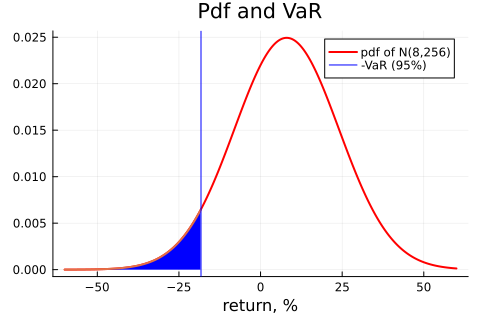

In [5]:
R    = range(-60,60,length=301)
pdfR = pdf.(Normal(μ,σ),R)
Rb   = R[R .<= -VaR₉₅]             #or filter(<=(-VaR₉₅),R)

p1 = plot( R,pdfR,
           linecolor = :red,
           linewidth = 2,
           label = "pdf of N($μ,$(σ^2))",
           title = "Pdf and VaR",
           xlabel = "return, %" )
plot!(Rb,pdf.(Normal(μ,σ),Rb),fillcolor=:red,linewidth=2,fill=(0,:blue),label="")
vline!([-VaR₉₅],linecolor=:blue,label="-VaR (95%)")
display(p1)

# Loading Daily S&P 500 Data

In [6]:
x  = readdlm("Data/SP500RfPs.csv",',',skipstart=1)
SP = x[:,2]                               #S&P 500 level
R  = (SP[2:end]./SP[1:end-1] .- 1) * 100  #returns, % 
T  = length(R)

dN = Date.(x[2:end,1],"d/m/y");    #convert to Date

println("Days in the sample: $T")

Days in the sample: 9352


# Backtesting a Static VaR from N() on Data

To backtest a VaR model, study the relative frequency of Loss > VaR. 

The code below does this for different confidence levels (0.95,0.96,...) of the VaR. For instance, at the 0.95 confidence levels we
1. calculate the VaR as the (negative of the) 0.05 quantile of a normal distribution (with mean and std estimated from the sample)
2. count the relative frequency of the loss > VaR (it should be 0.05).

In [7]:
μₑₘₚ = mean(R)                       #mean and std of data (empirical)
σₑₘₚ = std(R)

confLev = 0.95:0.005:0.995          #different confidence levels
L       = length(confLev)
Loss    = -R

(VaR_L,BreakFreq_L) = (fill(NaN,L),fill(NaN,L))   #for different confidence levels
for i = 1:L                 #loop over confidence levels
    VaR_L[i]       = -quantile(Normal(μₑₘₚ,σₑₘₚ),1-confLev[i])
    BreakFreq_L[i] = mean(Loss .> VaR_L[i]) #freq of breaking the VaR
end

printblue("Backtesting a static VaR:\n")
colNames = ["conf level","N()-based VaR","break freq"]
printmat([confLev VaR_L BreakFreq_L],colNames=colNames,width=18)

printred("The break frequency should be 1-confidence level")

Backtesting a static VaR:

        conf level     N()-based VaR        break freq
             0.950             1.790             0.041
             0.955             1.846             0.037
             0.960             1.907             0.034
             0.965             1.975             0.032
             0.970             2.052             0.029
             0.975             2.140             0.026
             0.980             2.244             0.023
             0.985             2.373             0.019
             0.990             2.547             0.016
             0.995             2.824             0.012

The break frequency should be 1-confidence level


The code below also studies the relative frequency of Loss > VaR, but over a moving data window (and only for a single confidence level, 0.95). This allows us to investigate if there are long periods of failures of the VaR model.

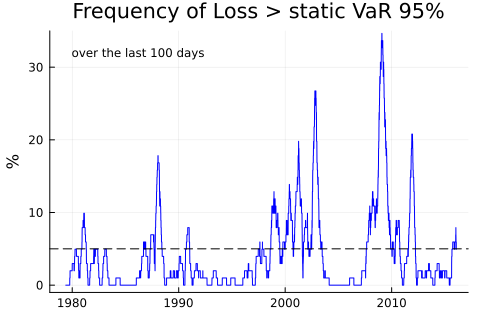

In [8]:
VaR = -quantile(Normal(μₑₘₚ,σₑₘₚ),0.05)  #static VAR at 95% confidence level

BreakFreq = fill(NaN,T)                #vector, freq(Loss>VaR) on moving data window
for t = 101:T
    BreakFreq[t] = mean(Loss[t-100:t] .> VaR)
end

xTicksLoc = [Date(1980);Date(1990);Date(2000);Date(2010)]
xTicksLab = Dates.format.(xTicksLoc,"Y")

p1 = plot( dN,BreakFreq*100,
           linecolor = :blue,
           ylim = (-1,35),
           legend = false,
           xticks = (xTicksLoc,xTicksLab),
           title = "Frequency of Loss > static VaR 95%",
           ylabel = "%",
           annotation = (Date(1980),32,text("over the last 100 days",8,:left)) )
hline!([5],linecolor=:black,line=(:dash,1))
display(p1)

# A Simple Dynamic VaR with Time-Varying Volatility

To improve the performance of the VaR model, we combine a simple time series model for volatility with an N()-based VaR calculation.

We first construct an simple estimate of $\sigma_t^2$ as a backward looking exponential moving average

$\sigma_t^2 = \lambda \sigma_{t-1}^2 + (1-\lambda) (R_{t-1} -\mu_{t-1})^2$,
where $\mu_{t}=\lambda \mu_{t-1} + (1-\lambda) R_{t-1}$ 

We then redo the $\textrm{VaR}_{95\%}$ calculation using

$\textrm{VaR}_{t} = - (\mu_t-1.64\sigma_t)$

and study if it has better properties than the static VaR.

In [9]:
λ   = 0.94
(μ,σ²) = (fill(μₑₘₚ,T),fill(σₑₘₚ^2,T)) #vectors, time-varying mean and variance
for t = 2:T
    μ[t]  = λ*μ[t-1]  + (1-λ)*R[t-1]
    σ²[t] = λ*σ²[t-1] + (1-λ)*(R[t-1]-μ[t-1])^2    #RiskMetrics approach
end

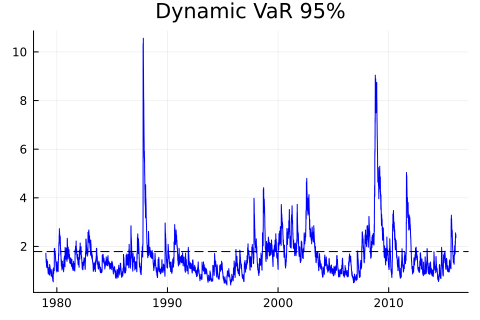

In [10]:
VaRd = fill(NaN,T)                        #dynamic VaR       
for t = 2:T
    VaRd[t] = -quantile(Normal(μ[t],sqrt(σ²[t])),0.05)   
end

p1 = plot( dN,VaRd,
           linecolor = :blue,
           #ylim = (-1,35),
           legend = false,
           xticks = (xTicksLoc,xTicksLab),
           title = "Dynamic VaR 95%",
           ylabel= "",
           annotation = (Date(1980),32,text("over the last 100 days",8,:left)) )
hline!([VaR],linecolor=:black,line=(:dash,1))
display(p1)

In [11]:
BreakFreq = fill(NaN,T)         #freq(Loss>VaR) on moving data window
for t = 101:T
    BreakFreq[t] = mean(Loss[t-100:t] .> VaRd[t-100:t])
end

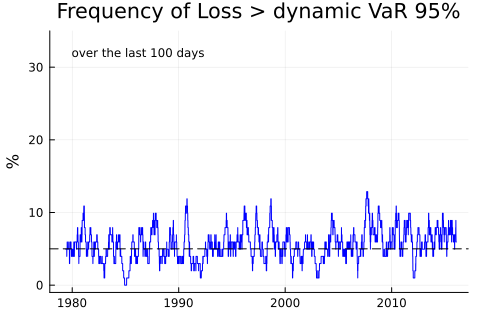

In [17]:
p1 = plot( dN,BreakFreq*100,
           linecolor = :blue,
           ylim = (-1,35),
           legend = false,
           xticks = (xTicksLoc,xTicksLab),
           title = "Frequency of Loss > dynamic VaR 95%",
           ylabel= "%",
           annotation = (Date(1980),32,text("over the last 100 days",8,:left)) )
hline!([5],linecolor=:black,line=(:dash,1))
display(p1)

# Expected Shortfall

The Expected Shortfall (ES) is the average loss, conditional on exceeding the VaR level

$
\text{ES}_{\alpha}=-\text{E}(R|R\leq-\text{VaR}_{\alpha})
$

For a normally distributed return $R\sim N(\mu,\sigma^{2})$ we have

$\text{ES}_{95\%}=-\left[\mu - \frac{\phi(-1.64)}{0.05}\sigma\right]$,

where $\phi()$ is the pdf of a $N(0,1)$ variable. For other confidence levels, change -1.64 and 0.05.

Alternatively, we can calculate the ES as 
`-mean(TruncatedNormal(μ,σ),-Inf,q))` where `q` is the quantile of the return distribution.

In [18]:
(μb,σb) = (8,16)

ES = -(μb - pdf(Normal(0,1),-1.64)/0.05*σb)

qb    = quantile(Normal(μb,σb),0.05)
ESb   = -mean(TruncatedNormal(μb,σb,-Inf,qb))        #more exact calculation

printblue("ES 95% with μ=$μb and σ=$σb is:\n")
printmat([ES,ESb];rowNames=["approx","exact"])

ES 95% with μ=8 and σ=16 is:

approx    25.268
exact     25.003



In [19]:
(VaRd,ESd) = (fill(NaN,T),fill(NaN,T))           #calculate a dynamic ES at the 95% conf level
for t = 2:T
    #local q_n, ER_n        #only needed in script
    q_n  = quantile(Normal(μ[t],sqrt(σ²[t])),0.05)
    ER_n = mean(TruncatedNormal(μ[t],sqrt(σ²[t]),-Inf,q_n))
    VaRd[t] = -q_n
    ESd[t]  = -ER_n
end

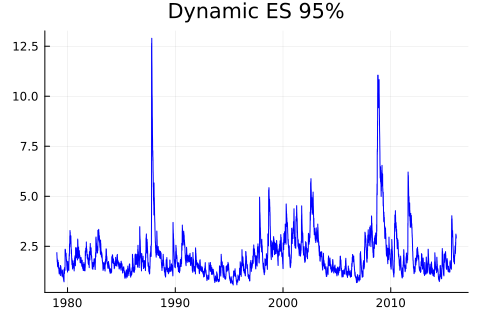

In [20]:
p1 = plot( dN,ESd,
           linecolor = :blue,
           legend = false,
           xticks = (xTicksLoc,xTicksLab),
           title = "Dynamic ES 95%",
           ylabel= "",
           annotation = (Date(1980),32,text("over the last 100 days",8,:left)) )
display(p1)

## Backtesting ES

by comparing the empirical average return  (conditional on loss > VaR) with the predictions from the model with N$(\mu_t,\sigma_t^2)$.

In [25]:
ES_backtest = fill(NaN,T,2)         #backtesting ES
for t = 101:T
  vv_t            = Loss[t-100:t] .> VaRd[t-100:t]
  ES_backtest[t,1] = mean(Loss[t-100:t][vv_t])           #mean empirical loss|loss>VaR
  ES_backtest[t,2] = mean(ESd[t-100:t][vv_t])            #mean N()-theoretical loss|loss>VaR    
end

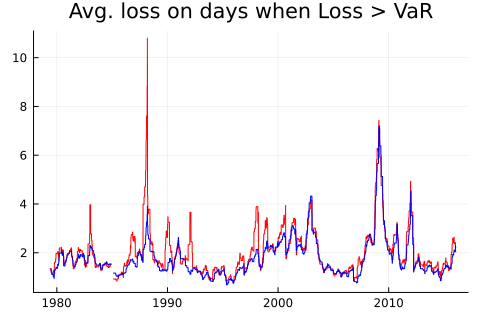

In [30]:
p1 = plot( dN,ES_backtest,
           linecolor = [:red :blue],
           legend = false,
           xticks = (xTicksLoc,xTicksLab),
           title = "Avg. loss on days when Loss > VaR",
           ylabel= "",
           annotation = (Date(1980),32,text("over the last 100 days",8,:left)) )
display(p1)